In [17]:
!pip install -q --upgrade pip
!pip install -q shapely
!pip install -q --upgrade pandas
!pip install -q --upgrade fsspec
!pip install -q pandarallel
!pip install -q googlemaps
!pip install -q geopandas
!pip install -q descartes
!pip install -q awswrangler
!pip install -q arcgis

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
python-language-server 0.31.7 requires ujson<=1.35; platform_system != "Windows", but you have ujson 4.0.2 which is incompatible.
python-jsonrpc-server 0.3.4 requires ujson<=1.35; platform_system != "Windows", but you have ujson 4.0.2 which is incompatible.


In [1]:
from sklearn.base import BaseEstimator, ClusterMixin
import random
import pandas as pd
import numpy as np
import copy
import types
from sklearn.utils.extmath import row_norms
from sklearn.cluster import kmeans_plusplus

def get_center_shift(centers, centers_old):
    shift = 0
    for center, center_old in zip(centers, centers_old):
        shift += np.linalg.norm(center - center_old)

    return shift
        
def get_distances(point:list, centers:list):
    distances = []
    for center in centers:
        distances.append(np.linalg.norm(center - point))
    return distances

def run_kmeans(X:list, centers:list, distance_function:types.LambdaType, cluster_iter:int, n_clusters:int, tol:float, verbose:bool):
    
    centers_old = np.zeros(centers.shape)

    labels = np.zeros(len(X))
    labels_old = np.zeros(len(X))
    
    for iter_n in range(cluster_iter):
        for i in range(len(X)):
            distances = distance_function(X[i], centers)
            cluster = np.argmin(distances)
            labels[i] = cluster
        
        for i in range(n_clusters):
            points = [X[j] for j in range(len(X)) if labels[j] == i]
            centers[i] = np.mean(points, axis=0)
        print('iter_n', iter_n)
        print(Counter(labels))
        print(centers)
        if np.array_equal(labels_old, labels):
            if verbose:
                print(f"Converged at iteration {iter_n}: strict convergence.")
            strict_convergence = True
            break
        else:
            center_shift_tot = get_center_shift(centers, centers_old)
            if center_shift_tot <= tol:
                if verbose:
                    print(f"Converged at iteration {iter_n}: center shift "
                          f"{center_shift_tot} within tolerance {tol}.")
                break
                
        centers_old = copy.deepcopy(centers)
        labels_old = copy.deepcopy(labels)
        print()
    return labels, centers

class Custom_Kmeans(BaseEstimator, ClusterMixin):
    
    def __init__(self, n_clusters: int, init:str='kmeans++', tol:float=1e-4 , cluster_iter:int=50, verbose:bool=True, distance_function:types.LambdaType=get_distances, random_state:int=0):
        self.n_clusters = n_clusters
        self.tol = tol
        self.init = init
        self.cluster_iter = cluster_iter
        self.verbose = verbose
        self.distance_function = distance_function
        self.random_state = random_state
             
    def _init_centroids(self, X:list, x_squared_norms:list):
        
        if isinstance(self.init, str) and self.init == 'random':
            centers = np.random.permutation(X)[:self.n_clusters]
        elif isinstance(self.init, str) and self.init == 'kmeans++':
            centers, _ = kmeans_plusplus(X, self.n_clusters,
                                          random_state=self.random_state,
                                          x_squared_norms=x_squared_norms)
        else:
            raise Exception('Not implemented')
            
        return centers
            
    def fit(self, X, y=None, sample_weight=None):
        
        x_squared_norms = row_norms(X, squared=True)
        centers = self._init_centroids(X, x_squared_norms)
        labels, centers = run_kmeans(X, centers, self.distance_function, self.cluster_iter, self.n_clusters, self.tol, self.verbose)
        
        self.labels = labels
        self.cluster_centers_ = centers

        return self
    
    def predict(self, X, sample_weight=None):
        pass
        

In [2]:
data = pd.read_csv('../../../Outputs/atenciones_filtradas.csv')

In [3]:
import arcgis
import pandas as pd
from arcgis.gis import GIS

df_routes = []

portal = GIS("https://www.arcgis.com", "dante_rivas_LearnArcGIS", "POSEIDON24")
route = arcgis.network.RouteLayer(portal.properties.helperServices.route.url,
                                          gis=portal)

ModuleNotFoundError: No module named 'arcgis'

In [4]:
def get_time_function(route):
    def get_time_distance(point:list, centers:list):
        distances = []
        for center in centers:
            stops = f"{point[1]},{point[0]};{center[1]},{center[0]}"

            result = route.solve(stops=stops,
                                    start_time="now",
                                    return_directions=False,
                                    directions_language="es",)

            time = result['routes']['features'][0]['attributes']['Total_TravelTime']
            distances.append(time)
            
        return distances
    
    return get_time_distance

In [21]:
from collections import Counter
kmeans = Custom_Kmeans(5)

In [22]:
kmeans.fit(data[['lat', 'lng']].values)

iter_n 0
Counter({0.0: 163, 1.0: 142, 4.0: 64, 3.0: 7, 2.0: 7})
[[-12.12333655 -76.97757182]
 [-12.0913544  -77.04683365]
 [-11.87500034 -77.08289941]
 [-11.9859572  -76.79706467]
 [-12.00877097 -77.06665801]]

iter_n 1
Counter({0.0: 175, 1.0: 132, 4.0: 55, 3.0: 11, 2.0: 10})
[[-12.126225   -76.98318265]
 [-12.08543897 -77.05285724]
 [-11.89205642 -77.0759234 ]
 [-11.99927859 -76.83345045]
 [-12.00698692 -77.06289346]]

iter_n 2
Counter({0.0: 183, 1.0: 131, 4.0: 43, 2.0: 15, 3.0: 11})
[[-12.12561687 -76.9846779 ]
 [-12.08216662 -77.05679455]
 [-11.9097542  -77.06989579]
 [-11.99927859 -76.83345045]
 [-12.00637524 -77.05971892]]

iter_n 3
Counter({0.0: 185, 1.0: 131, 4.0: 38, 2.0: 18, 3.0: 11})
[[-12.12557654 -76.98516878]
 [-12.08124571 -77.05941157]
 [-11.91696369 -77.06790545]
 [-11.99927859 -76.83345045]
 [-12.00768339 -77.05239619]]

iter_n 4
Counter({0.0: 189, 1.0: 128, 4.0: 36, 2.0: 19, 3.0: 11})
[[-12.12511528 -76.98595068]
 [-12.08024611 -77.06171601]
 [-11.91919194 -77.0683328

Custom_Kmeans(n_clusters=5)

In [30]:
from sklearn.cluster import KMeans

normal_kmeans = KMeans(5, random_state=0)
normal_kmeans.fit(data[['lat', 'lng']].values)

KMeans(n_clusters=5, random_state=0)

In [31]:
normal_kmeans.cluster_centers_

array([[-12.11241613, -76.99220171],
       [-11.95405367, -77.06404449],
       [-11.99927859, -76.83345045],
       [-12.0700392 , -77.0626685 ],
       [-12.19010595, -76.97406887]])

In [23]:
kmeans.cluster_centers_

array([[-12.12506342, -76.98711965],
       [-12.08042161, -77.06535555],
       [-11.91919194, -77.06833282],
       [-11.99927859, -76.83345045],
       [-12.01382201, -77.04114574]])

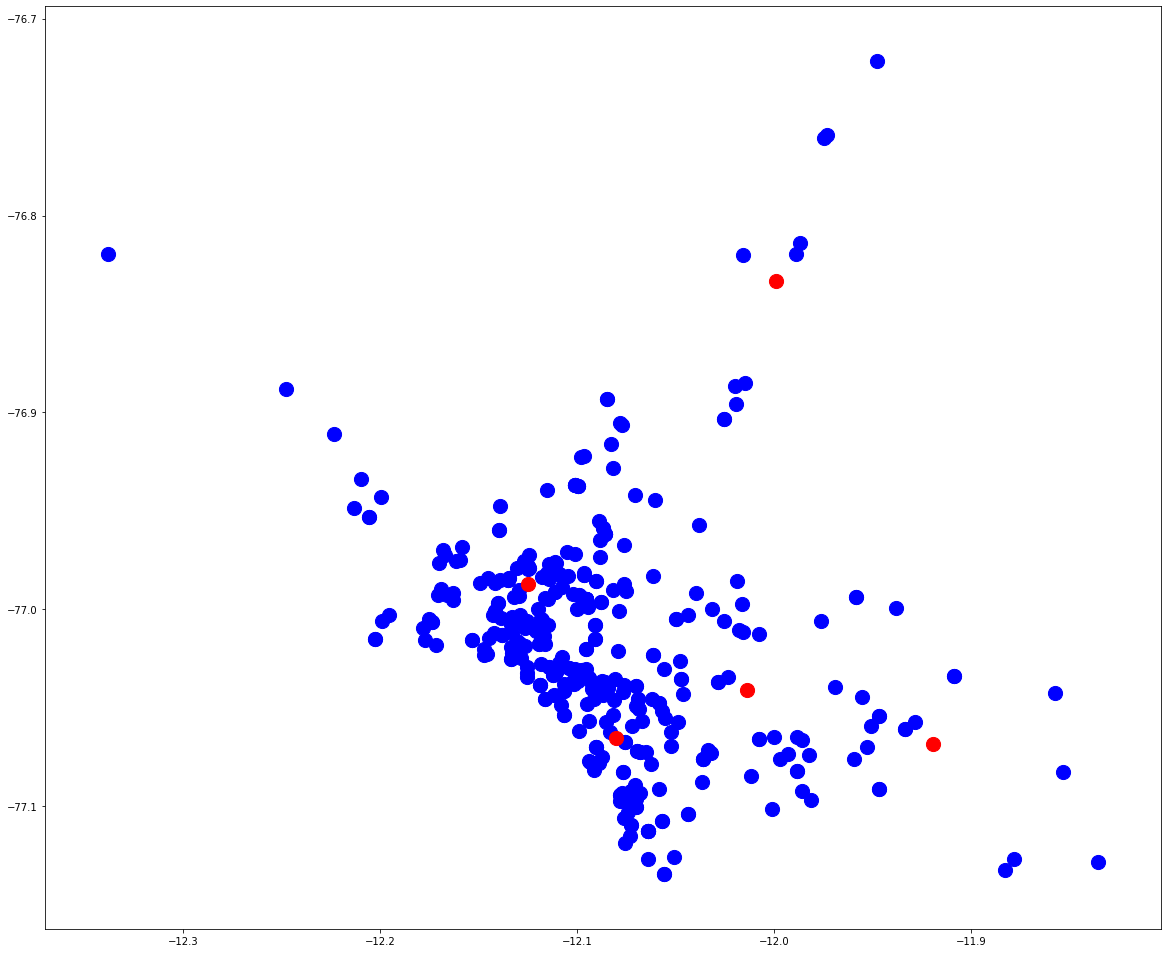

In [24]:
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rc('figure', figsize=(8, 8))

import geopandas as gpd
from shapely.geometry import Point, Polygon

fig, ax = plt.subplots(figsize=(20,20))

amb_points = [Point(x, y) for x, y in kmeans.cluster_centers_]
red_points = [Point(x, y) for x, y in zip(data.lat.values, data.lng.values)]

all_points = list(red_points) + amb_points
types = [0]*len(red_points) + [1]*len(amb_points)

results = pd.DataFrame()
results['geometry'] = all_points
results['types'] = types

df_geo = gpd.GeoDataFrame(results, geometry=all_points)
df_geo.loc[df_geo.types == 0].geometry.plot(ax=ax, color="blue", markersize=200)
df_geo.loc[df_geo.types == 1].geometry.plot(ax=ax, color="red", markersize=200)

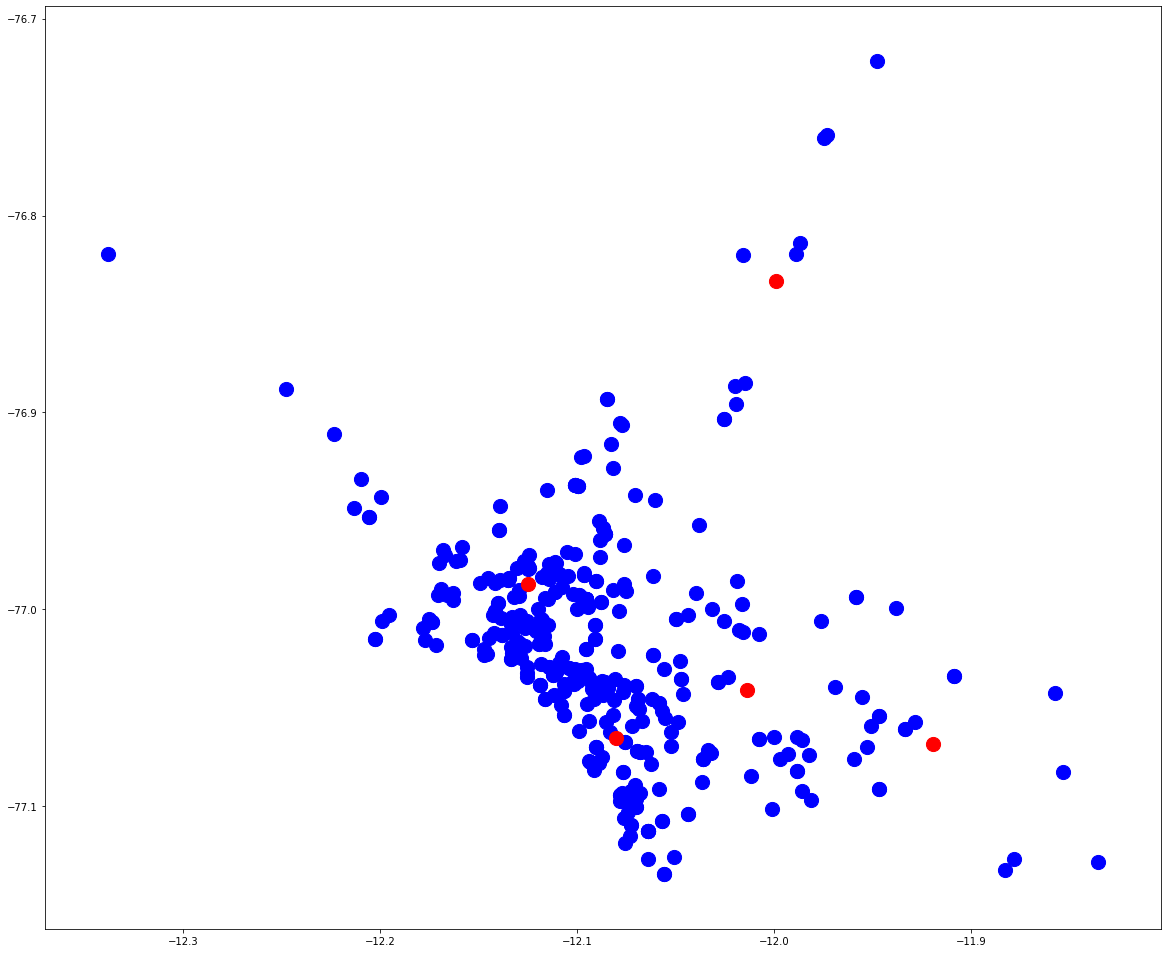

In [29]:
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rc('figure', figsize=(8, 8))

import geopandas as gpd
from shapely.geometry import Point, Polygon

fig, ax = plt.subplots(figsize=(20,20))

amb_points = [Point(x, y) for x, y in kmeans.cluster_centers_]
red_points = [Point(x, y) for x, y in zip(data.lat.values, data.lng.values)]

all_points = list(red_points) + amb_points
types = [0]*len(red_points) + [1]*len(amb_points)

results = pd.DataFrame()
results['geometry'] = all_points
results['types'] = types

df_geo = gpd.GeoDataFrame(results, geometry=all_points)
df_geo.loc[df_geo.types == 0].geometry.plot(ax=ax, color="blue", markersize=200)
df_geo.loc[df_geo.types == 1].geometry.plot(ax=ax, color="red", markersize=200)